# Import

In [15]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 199)

from datetime import datetime
import re
import os
import os.path
import math
import sys
import csv
import glob
import seaborn as sns
import numpy as np
import shap 
from collections import Counter

# import mlflow
# import mlflow.sklearn
# import pysftp

from sklearn.metrics import confusion_matrix
import seaborn as sns
pd.options.display.float_format = "{:.2f}".format

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm 

import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss, roc_auc_score, f1_score

%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/utils.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/visualization/common_visualization.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/common_eda.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/modelling/regression_model.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/common_dictionary.py"

print("current working folder: ", os.getcwd())
user_name = "chaupham"
# print("notebook kernel id: ", get_notebook_kernel_id())

current working folder:  /Users/chau/minhchau/jupyter_projects/plant_project


# Helper funcs

In [16]:
def convert_to_up_down_noChange(x, thres, c, base_col):
    if x[c] - x[base_col] > thres:  ##UP
        return "2"
    elif x[c] + thres < x[base_col]:
        return  "1" ## DOWN
    else:
        return "0" # NO_CHANGE

# Read input

In [17]:
df = pd.read_csv("./data/cleaned_data.csv")
df.shape                 

(20450, 14)

In [18]:
df.label.value_counts()

0    19245
1     1205
Name: label, dtype: int64

In [19]:
df.head()

,atID,wthp6,wthp6_2,wtlp6,wtlp6_2,wthp5,wthp5_2,wtlp5,wtlp5_2,wtal,wtal_2,wtfe,wtfe_2,label
0,AT1G01020,18.51,17.60,17.80,20.36,18.99,21.93,18.29,21.48,19.01,17.58,18.21,18.19,0
1,AT1G01030,0.82,1.07,0.68,0.45,0.54,0.40,0.56,0.29,0.22,0.81,0.93,0.62,1
2,AT1G01040,36.57,34.09,31.92,53.51,37.06,34.78,43.44,49.22,42.09,36.11,32.94,17.10,0
3,AT1G01050,103.58,109.89,103.21,96.22,100.88,106.00,97.60,100.95,89.76,92.77,91.97,112.10,0
4,AT1G01060,1.94,1.78,2.93,2.88,3.15,3.67,2.44,2.13,1.34,1.89,3.52,1.89,1


In [20]:
wt_cols = ['wthp6', 'wtlp6',  'wthp5',  'wtlp5',  'wtal',  'wtfe']
wt_conditioned_cols = wt_cols[1:]
base_col= wt_cols[0]
wt_BIT_cols = [c+"_BIT" for c in wt_conditioned_cols]

for c in wt_cols:
    df[c + "_ave"] = (df[c] + df[c + "_2"]) / 2
    
df.columns

Index(['atID', 'wthp6', 'wthp6_2', 'wtlp6', 'wtlp6_2', 'wthp5', 'wthp5_2', 'wtlp5', 'wtlp5_2',
       'wtal', 'wtal_2', 'wtfe', 'wtfe_2', 'label', 'wthp6_ave', 'wtlp6_ave', 'wthp5_ave',
       'wtlp5_ave', 'wtal_ave', 'wtfe_ave'],
      dtype='object')

In [21]:
data_df = df[['atID', 'label', 'wthp6_ave', 'wtlp6_ave', 'wthp5_ave', 'wtlp5_ave', 'wtal_ave', 'wtfe_ave']]
data_df.columns = ['atID', 'label', 'wthp6', 'wtlp6', 'wthp5', 'wtlp5', 'wtal', 'wtfe']

In [22]:
data_df.head()

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe
0,AT1G01020,0,18.06,19.08,20.46,19.88,18.30,18.20
1,AT1G01030,1,0.94,0.57,0.47,0.43,0.52,0.77
2,AT1G01040,0,35.33,42.71,35.92,46.33,39.10,25.02
3,AT1G01050,0,106.73,99.72,103.44,99.28,91.26,102.04
4,AT1G01060,1,1.86,2.91,3.41,2.29,1.61,2.71


In [23]:
def get_L1_raw(x):
    return np.sum(np.abs([x[c] - x[base_col] for c in wt_conditioned_cols]))
    
def get_L2_raw(x):
    return np.sum(np.square([x[c] - x[base_col] for c in wt_conditioned_cols]))
    
def get_L1_norm(x):
    max_x = np.amax(x[wt_cols])
    x[wt_cols] = x[wt_cols]/max_x
    return get_L1_raw(x)

def get_L2_norm(x):
    max_x = np.amax(x[wt_cols])
    x[wt_cols] = x[wt_cols]/max_x
    return get_L2_raw(x)

def get_L1_Log2Fold(x):
    return np.sum(np.abs( np.log2([x[c] / x[base_col] for c in wt_conditioned_cols])) )

def get_L2_Log2Fold(x):
    return np.sum(np.abs( np.log2([x[c] / x[base_col] for c in wt_conditioned_cols])) )

    

In [24]:
data_df["L1_raw"] = data_df.apply(get_L1_raw, 1)
data_df["L2_raw"] = data_df.apply(get_L2_raw, 1)
data_df["L1_norm"] = data_df.apply(get_L1_norm, 1)
data_df["L2_norm"] = data_df.apply(get_L2_norm, 1)

data_df.head()

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L1_raw,L2_raw,L1_norm,L2_norm
0,AT1G01020,0,18.06,19.08,20.46,19.88,18.30,18.20,5.63,10.23,0.28,0.02
1,AT1G01030,1,0.94,0.57,0.47,0.43,0.52,0.77,1.95,0.84,2.07,0.94
2,AT1G01040,0,35.33,42.71,35.92,46.33,39.10,25.02,33.07,296.44,0.71,0.14
3,AT1G01050,0,106.73,99.72,103.44,99.28,91.26,102.04,37.93,377.02,0.36,0.03
4,AT1G01060,1,1.86,2.91,3.41,2.29,1.61,2.71,4.12,4.47,1.21,0.38


In [25]:
data_df.label.value_counts()

0    19245
1     1205
Name: label, dtype: int64

In [94]:
data_df.shape

(20450, 18)

In [82]:
thres = 1

for c in wt_conditioned_cols:
    data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange(x, thres, c, base_col), 1)

data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
stats_data_df

,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,#genes,#TF(s),%TF
0,0,0,0,0,0,2634,180,6.83
1,1,1,1,1,1,1494,59,3.95
2,2,2,2,2,2,980,59,6.02
3,2,2,2,2,1,905,42,4.64
4,1,1,1,1,2,818,11,1.34
5,0,0,0,0,2,668,55,8.23
6,0,0,0,2,2,396,36,9.09
7,0,0,0,0,1,321,24,7.48
8,0,2,2,2,2,303,21,6.93
9,2,0,2,2,1,303,16,5.28


In [85]:
stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
# stats_data_df.head()

In [84]:
data_df_class_1_only = data_df[data_df.label == 1]
stats_class_1_only = data_df_class_1_only[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
stats_class_1_only

,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,#genes,#TF(s)
0,0,0,0,0,0,180,180
1,1,1,1,1,1,59,59
2,2,2,2,2,2,59,59
3,0,0,0,0,2,55,55
4,2,2,2,2,1,42,42
5,0,0,0,2,2,36,36
6,0,0,0,0,1,24,24
7,0,0,2,2,2,22,22
8,0,2,2,2,2,21,21
9,2,2,2,0,2,21,21


In [88]:
DataFrameDict["00000"]["data"].sort_values("L1_raw")

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L1_raw,L2_raw,L1_norm,L2_norm
7446,AT2G35950,0,0.10,0.10,0.09,0.12,0.16,0.09,0.09,0.00,0.58,0.16
13766,AT4G17660,0,0.03,0.02,0.02,0.02,0.04,0.09,0.10,0.01,1.11,0.58
10832,AT3G28150,0,0.53,0.47,0.51,0.53,0.53,0.52,0.12,0.00,0.23,0.02
11917,AT3G55677,0,0.00,0.00,0.00,0.00,0.00,0.14,0.14,0.02,1.00,1.00
13043,AT4G08550,0,0.00,0.00,0.00,0.00,0.03,0.12,0.15,0.01,1.24,1.06
4837,AT1G74190,0,0.03,0.00,0.00,0.00,0.06,0.07,0.15,0.00,2.15,0.98
7212,AT2G33000,0,1.07,1.11,1.05,1.07,0.98,1.08,0.16,0.01,0.14,0.01
19133,AT5G52400,0,0.00,0.00,0.00,0.07,0.11,0.00,0.19,0.02,1.65,1.42
18992,AT5G50360,0,0.08,0.00,0.00,0.05,0.07,0.09,0.20,0.01,2.18,1.49
17832,AT5G28010,0,0.56,0.54,0.52,0.69,0.57,0.54,0.23,0.02,0.33,0.04


In [65]:
interesting_cols = ['atID', 'label'] + wt_cols + ["L1_raw", "L2_raw", "L1_norm", "L2_norm"]
unique_groups = stats_data_df.group_id
DataFrameDict = dict()
summary = dict()
sort_cols = ["L1_raw", "L2_raw", "L1_norm", "L2_norm"]

for sort_col in sort_cols:
    summary[sort_col] = dict()
    summary[sort_col]["num_tf"] = list()
    summary[sort_col]["percent_tf"] = list()
    summary[sort_col]["auc"] = list()
    
   
    
for key in unique_groups:
    DataFrameDict[key] = dict()
    DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
    DataFrameDict[key]["result"] = dict()
    
    for sort_col in sort_cols:
        DataFrameDict[key]["result"][sort_col] = dict()
        tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
        total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
        num_tf_candidates_in_the_top = tmp.head(total_tf_candidates)["label"].sum()
        percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
        try:
            auc = roc_auc_score(tmp.label, tmp[sort_col])
            summary[sort_col]["auc"].append(auc)
            DataFrameDict[key]["result"][sort_col]['auc'] = auc
            
        except:
            pass

        summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
        summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)
        
        DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
        DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
        

In [69]:
print("THRESHOLD = ", thres)
for sort_col in sort_cols:
    print("\t", sort_col)
    for key,val in summary[sort_col].items():
        print(f"{key}, {val}, sum is {np.nansum(val)}, mean is {np.nanmean(val)}", end="\n\n")
        
#         print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
    
    print("\t\t---")
print("=============")

THRESHOLD =  1
	 L1_raw
num_tf, [16, 5, 3, 6, 2, 10, 3, 4, 1, 1, 2, 1, 1, 3, 1, 1, 2, 2, 1, 1, 0, 2, 0, 1, 0, 3, 0, 4, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], sum is 123, mean is 0.5082644628099173

percent_tf, [8.89, 8.47, 5.08, 14.29, 18.18, 18.18, 8.33, 16.67, 4.76, 6.25, 16.67, 7.14, 8.33, 14.29, 20.0, 7.69, 11.11, 15.38, 4.55, 7.69, 0.0, 25.0, 0.0, 11.11, 0.0, 30.0, 0.0, 30.77, 0.0, 28.57,

In [45]:
def run_all(thres_list):
    summary_ALL = {}
    short_res = {}
    short_res['L1_raw'] = []
    short_res['L2_raw'] = []
    short_res['L1_norm'] = []
    short_res['L2_norm'] = []

    
    for thres in thres_list:
        for c in wt_conditioned_cols:
            data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange(x, thres, c, base_col), 1)

        data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

        stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
        stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
        stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
        
    
        
        unique_groups = stats_data_df.group_id
        DataFrameDict = dict()
        summary = dict()

        for sort_col in sort_cols:
            summary[sort_col] = dict()
            summary[sort_col]["num_tf"] = list()
            summary[sort_col]["percent_tf"] = list()
            summary[sort_col]["auc"] = list()


        for key in unique_groups:
            DataFrameDict[key] = dict()
            DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
            DataFrameDict[key]["result"] = dict()

            for sort_col in sort_cols:
                DataFrameDict[key]["result"][sort_col] = dict()
                tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
                total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
                num_tf_candidates_in_the_top = tmp.head(total_tf_candidates)["label"].sum()
                percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
                try:
                    auc = roc_auc_score(tmp.label, tmp[sort_col])
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                except:
                    pass

                summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
                summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)

#                 DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
#                 DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
                
        summary_ALL[thres] = summary
        print("THRESHOLD = ", thres)
        for sort_col in sort_cols:
            print("\t", sort_col)
            for key,val in summary[sort_col].items():
                print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
                
            short_res[sort_col].append(sum(summary[sort_col]["num_tf"]))

            print("\t\t---")
        print("=============")
    return summary_ALL, short_res

In [ ]:
for k, v in short_res.items():
    print(k, np.amax(v))

In [74]:
thres_list = np.arange(0, 15, 0.1)
summary_ALL_, short_res_ = run_all(thres_list)
short_res_

THRESHOLD =  0.0
	 L1_raw
		 num_tf: sum is 87, mean is 1.9772727272727273
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 15.084712049622885, mean is 0.45711248635220875
		---
	 L2_raw
		 num_tf: sum is 87, mean is 1.9772727272727273
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 15.101986262792432, mean is 0.45763594735734636
		---
	 L1_norm
		 num_tf: sum is 61, mean is 1.3863636363636365
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 18.220023135621254, mean is 0.5521219132006441
		---
	 L2_norm
		 num_tf: sum is 66, mean is 1.5
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 18.25315969387264, mean is 0.5531260513294739
		---
THRESHOLD =  0.1
	 L1_raw
		 num_tf: sum is 95, mean is 0.3958333333333333
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 69.81859231462573, mean is 0.49168022756778684
		---
	 L2_raw
		 num_tf: sum is 97, mean is 0.4041666666666667
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 70.24070314174367, mean is 0.494652839026

THRESHOLD =  1.2000000000000002
	 L1_raw
		 num_tf: sum is 108, mean is 0.4462809917355372
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 83.61066757527664, mean is 0.4723766529676646
		---
	 L2_raw
		 num_tf: sum is 105, mean is 0.43388429752066116
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 83.1766891878423, mean is 0.46992479767142525
		---
	 L1_norm
		 num_tf: sum is 77, mean is 0.3181818181818182
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 97.12358776286855, mean is 0.5487208348184665
		---
	 L2_norm
		 num_tf: sum is 74, mean is 0.30578512396694213
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 96.52906685874503, mean is 0.545361959653927
		---
THRESHOLD =  1.3
	 L1_raw
		 num_tf: sum is 92, mean is 0.3817427385892116
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 82.07138420199186, mean is 0.46897933829709604
		---
	 L2_raw
		 num_tf: sum is 96, mean is 0.3983402489626556
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 81.3000599107

THRESHOLD =  2.4000000000000004
	 L1_raw
		 num_tf: sum is 110, mean is 0.46808510638297873
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 69.38890375361264, mean is 0.4720333588681132
		---
	 L2_raw
		 num_tf: sum is 108, mean is 0.4595744680851064
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 68.86459983606767, mean is 0.46846666555148053
		---
	 L1_norm
		 num_tf: sum is 74, mean is 0.3148936170212766
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 83.45959105995026, mean is 0.5677523201357161
		---
	 L2_norm
		 num_tf: sum is 81, mean is 0.3446808510638298
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 82.18785939771932, mean is 0.5591010843382268
		---
THRESHOLD =  2.5
	 L1_raw
		 num_tf: sum is 113, mean is 0.4808510638297872
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 69.58880544296328, mean is 0.47339323430587255
		---
	 L2_raw
		 num_tf: sum is 111, mean is 0.4723404255319149
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 69.0961939

THRESHOLD =  3.6
	 L1_raw
		 num_tf: sum is 96, mean is 0.4155844155844156
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 59.03441860757807, mean is 0.4648379417919534
		---
	 L2_raw
		 num_tf: sum is 92, mean is 0.39826839826839827
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 59.26116888714163, mean is 0.46662337706410734
		---
	 L1_norm
		 num_tf: sum is 66, mean is 0.2857142857142857
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 70.22093402373986, mean is 0.5529207403444084
		---
	 L2_norm
		 num_tf: sum is 71, mean is 0.30735930735930733
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 70.52137748727466, mean is 0.5552864369076744
		---
THRESHOLD =  3.7
	 L1_raw
		 num_tf: sum is 100, mean is 0.43859649122807015
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 56.744695068512364, mean is 0.45035472276597127
		---
	 L2_raw
		 num_tf: sum is 95, mean is 0.4166666666666667
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 57.18728335557371, mean i

THRESHOLD =  4.800000000000001
	 L1_raw
		 num_tf: sum is 90, mean is 0.40358744394618834
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 46.19587546930279, mean is 0.4124631738330607
		---
	 L2_raw
		 num_tf: sum is 90, mean is 0.40358744394618834
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 45.67062679112654, mean is 0.40777345349220123
		---
	 L1_norm
		 num_tf: sum is 61, mean is 0.273542600896861
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 58.445284701677494, mean is 0.5218328991221206
		---
	 L2_norm
		 num_tf: sum is 66, mean is 0.29596412556053814
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 58.85650594094183, mean is 0.5255045173298377
		---
THRESHOLD =  4.9
	 L1_raw
		 num_tf: sum is 91, mean is 0.40444444444444444
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 46.79363996048403, mean is 0.41780035679003585
		---
	 L2_raw
		 num_tf: sum is 95, mean is 0.4222222222222222
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 46.611433168

THRESHOLD =  6.0
	 L1_raw
		 num_tf: sum is 91, mean is 0.4117647058823529
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 46.35636891809383, mean is 0.4730241726336103
		---
	 L2_raw
		 num_tf: sum is 91, mean is 0.4117647058823529
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 45.061914359847016, mean is 0.4598154526515001
		---
	 L1_norm
		 num_tf: sum is 58, mean is 0.26244343891402716
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 53.34289887094833, mean is 0.5443152946015135
		---
	 L2_norm
		 num_tf: sum is 64, mean is 0.2895927601809955
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 52.216689473690124, mean is 0.5328233619764297
		---
THRESHOLD =  6.1000000000000005
	 L1_raw
		 num_tf: sum is 91, mean is 0.41935483870967744
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 45.260553363256264, mean is 0.4764268775079607
		---
	 L2_raw
		 num_tf: sum is 86, mean is 0.39631336405529954
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 44.19333755

THRESHOLD =  7.2
	 L1_raw
		 num_tf: sum is 81, mean is 0.3932038834951456
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 37.4258068754745, mean is 0.46204699846264796
		---
	 L2_raw
		 num_tf: sum is 73, mean is 0.35436893203883496
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 37.600112861061355, mean is 0.4641989242106339
		---
	 L1_norm
		 num_tf: sum is 56, mean is 0.27184466019417475
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 45.447128213225746, mean is 0.5610756569534043
		---
	 L2_norm
		 num_tf: sum is 62, mean is 0.30097087378640774
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 46.02651823284333, mean is 0.5682286201585598
		---
THRESHOLD =  7.300000000000001
	 L1_raw
		 num_tf: sum is 79, mean is 0.3853658536585366
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 38.525733189303175, mean is 0.4698260145036971
		---
	 L2_raw
		 num_tf: sum is 73, mean is 0.35609756097560974
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 38.72720262

THRESHOLD =  8.4
	 L1_raw
		 num_tf: sum is 94, mean is 0.47474747474747475
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 30.15489263692477, mean is 0.44345430348418774
		---
	 L2_raw
		 num_tf: sum is 95, mean is 0.4797979797979798
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 30.098900244723172, mean is 0.4426308859518114
		---
	 L1_norm
		 num_tf: sum is 55, mean is 0.2777777777777778
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 37.137398871272644, mean is 0.5461382186951859
		---
	 L2_norm
		 num_tf: sum is 61, mean is 0.30808080808080807
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 37.4700339011047, mean is 0.5510299103103631
		---
THRESHOLD =  8.5
	 L1_raw
		 num_tf: sum is 95, mean is 0.4846938775510204
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 29.97747501586863, mean is 0.44084522082159744
		---
	 L2_raw
		 num_tf: sum is 96, mean is 0.4897959183673469
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 29.950464699736607, mean is

THRESHOLD =  9.600000000000001
	 L1_raw
		 num_tf: sum is 84, mean is 0.4307692307692308
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 28.27116591152497, mean is 0.4634617362545076
		---
	 L2_raw
		 num_tf: sum is 84, mean is 0.4307692307692308
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 28.921820683447336, mean is 0.474128207925366
		---
	 L1_norm
		 num_tf: sum is 53, mean is 0.2717948717948718
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 33.504262494510634, mean is 0.5492502048280432
		---
	 L2_norm
		 num_tf: sum is 61, mean is 0.3128205128205128
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 33.9321151071044, mean is 0.5562641820836787
		---
THRESHOLD =  9.700000000000001
	 L1_raw
		 num_tf: sum is 81, mean is 0.413265306122449
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 27.95555583728806, mean is 0.4659259306214676
		---
	 L2_raw
		 num_tf: sum is 80, mean is 0.40816326530612246
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 28.3

THRESHOLD =  10.8
	 L1_raw
		 num_tf: sum is 84, mean is 0.4421052631578947
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 22.85242330229642, mean is 0.4231930241166005
		---
	 L2_raw
		 num_tf: sum is 79, mean is 0.41578947368421054
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 23.30048883245387, mean is 0.43149053393433107
		---
	 L1_norm
		 num_tf: sum is 54, mean is 0.28421052631578947
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 29.473498282279955, mean is 0.5458055237459253
		---
	 L2_norm
		 num_tf: sum is 59, mean is 0.3105263157894737
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 29.364881774328197, mean is 0.5437941069320037
		---
THRESHOLD =  10.9
	 L1_raw
		 num_tf: sum is 85, mean is 0.4473684210526316
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 21.589682204921907, mean is 0.4073524944324887
		---
	 L2_raw
		 num_tf: sum is 81, mean is 0.4263157894736842
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 21.87464804404407, mean 

THRESHOLD =  12.0
	 L1_raw
		 num_tf: sum is 82, mean is 0.44086021505376344
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 20.3276721402113, mean is 0.39858180667080984
		---
	 L2_raw
		 num_tf: sum is 83, mean is 0.44623655913978494
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 21.574014110090154, mean is 0.42301988451157185
		---
	 L1_norm
		 num_tf: sum is 55, mean is 0.2956989247311828
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 26.74186960986747, mean is 0.5243503845072053
		---
	 L2_norm
		 num_tf: sum is 60, mean is 0.3225806451612903
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 26.54356181610881, mean is 0.5204619963942902
		---
THRESHOLD =  12.100000000000001
	 L1_raw
		 num_tf: sum is 83, mean is 0.4486486486486487
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 20.258656896327935, mean is 0.4051731379265588
		---
	 L2_raw
		 num_tf: sum is 83, mean is 0.4486486486486487
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 21.53805290

THRESHOLD =  13.200000000000001
	 L1_raw
		 num_tf: sum is 77, mean is 0.41621621621621624
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 17.447704844011895, mean is 0.41542154390504504
		---
	 L2_raw
		 num_tf: sum is 76, mean is 0.41081081081081083
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 18.412440547540076, mean is 0.43839144160809695
		---
	 L1_norm
		 num_tf: sum is 51, mean is 0.2756756756756757
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 21.445545168863237, mean is 0.5106082183062675
		---
	 L2_norm
		 num_tf: sum is 59, mean is 0.31891891891891894
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 20.36088756302534, mean is 0.484783037214889
		---
THRESHOLD =  13.3
	 L1_raw
		 num_tf: sum is 77, mean is 0.41397849462365593
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 18.12255660802783, mean is 0.4214548048378566
		---
	 L2_raw
		 num_tf: sum is 76, mean is 0.40860215053763443
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 18.4680

THRESHOLD =  14.4
	 L1_raw
		 num_tf: sum is 80, mean is 0.43478260869565216
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 16.802588462442213, mean is 0.4098192307912734
		---
	 L2_raw
		 num_tf: sum is 75, mean is 0.4076086956521739
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 17.050503595201814, mean is 0.41586594134638577
		---
	 L1_norm
		 num_tf: sum is 52, mean is 0.2826086956521739
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 20.895965816238686, mean is 0.5096577028350899
		---
	 L2_norm
		 num_tf: sum is 61, mean is 0.33152173913043476
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 20.58590810140208, mean is 0.5020953195463923
		---
THRESHOLD =  14.5
	 L1_raw
		 num_tf: sum is 80, mean is 0.4371584699453552
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 17.034735212782852, mean is 0.4154813466532403
		---
	 L2_raw
		 num_tf: sum is 76, mean is 0.41530054644808745
		 percent_tf: sum is nan, mean is nan
		 auc: sum is 17.172037863403148, me

{'L1_raw': [87,
  95,
  89,
  105,
  101,
  94,
  96,
  101,
  108,
  106,
  123,
  121,
  108,
  92,
  90,
  87,
  82,
  89,
  85,
  88,
  93,
  101,
  101,
  111,
  110,
  113,
  116,
  112,
  107,
  94,
  94,
  90,
  95,
  93,
  91,
  92,
  96,
  100,
  93,
  88,
  89,
  96,
  95,
  96,
  92,
  92,
  94,
  95,
  90,
  91,
  95,
  91,
  89,
  86,
  89,
  88,
  87,
  86,
  86,
  91,
  91,
  91,
  92,
  93,
  93,
  88,
  89,
  87,
  86,
  87,
  82,
  81,
  81,
  79,
  82,
  81,
  82,
  83,
  83,
  86,
  89,
  91,
  92,
  92,
  94,
  95,
  90,
  91,
  90,
  90,
  88,
  83,
  81,
  84,
  83,
  82,
  84,
  81,
  82,
  85,
  85,
  84,
  84,
  84,
  86,
  88,
  87,
  85,
  84,
  85,
  86,
  84,
  83,
  81,
  82,
  81,
  83,
  81,
  82,
  82,
  82,
  83,
  81,
  82,
  81,
  80,
  81,
  79,
  78,
  79,
  79,
  80,
  77,
  77,
  78,
  78,
  78,
  77,
  77,
  76,
  77,
  77,
  81,
  80,
  80,
  80,
  80,
  78,
  78,
  78],
 'L2_raw': [87,
  97,
  90,
  103,
  103,
  94,
  94,
  91,
  98,
  108,

In [76]:
for k, v in short_res_.items():
    print(k, np.amax(v))

L1_raw 123
L2_raw 121
L1_norm 79
L2_norm 87


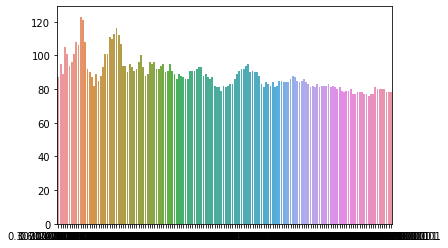

In [77]:
sns.barplot(x=thres_list, y=short_res_["L1_raw"])